In [72]:
# Load the data
import pandas as pd
import json

data_frame_wcus = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wcus-db1.csv"))
data_frame_wus2_db1 = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wus2-db1.csv"))
data_frame_wus2_db2 = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wus2-db2.csv"))
data_frame_wus2_db3 = pd.DataFrame(pd.read_csv("./data/alert-source-investigation-wus2-db3.csv"))

data_frame = pd.concat([data_frame_wcus, data_frame_wus2_db1, data_frame_wus2_db2, data_frame_wus2_db3], sort=False)

data_frame.reset_index()

,index,partitionid,dataspaceid,repositoryid,alertid,title,alertkey,severity,component_type,sources
0,0,2,138,524,77111,CVE-2021-42322,v6:b1885491cc96474fb5c86e29bd2a1782,2,9,"{""WhiteSource"":{""Url"":""https://cve.mitre.org/c..."
1,1,2,138,524,58878,CVE-2021-28469,v6:0237b3f7880546f684ecdd8153774ca9,1,9,"{""WhiteSource"":{""Url"":""https://cve.mitre.org/c..."
2,2,2,138,524,58877,CVE-2021-28477,v6:16fdc8414ac94318961c4a99e9cac532,1,9,"{""WhiteSource"":{""Url"":""https://cve.mitre.org/c..."
3,3,2,138,524,58876,CVE-2021-28473,v6:65bea5e09b1c4b86ba4985ea43768516,1,9,"{""WhiteSource"":{""Url"":""https://cve.mitre.org/c..."
4,4,2,138,524,75692,GHSA-8f93-rv4p-x4jw,v6:01f957915b0b416194fa55ce400c96b2,1,2,"{""GitHubAdvisories"":{""Url"":""https://hackerone...."
...,...,...,...,...,...,...,...,...,...,...
15269,1772,38266,280867,196823,7038930,CVE-2021-30641,v6:7081554336a54733bc8fed236bf815cb,1,13,"{""Debian"":{""Url"":""https://security-tracker.deb..."
15270,1773,38266,280867,196823,7038931,CVE-2021-44790,v6:82f987a4903f494db7a80f01f4c8d97a,1,13,"{""Debian"":{""Url"":""https://security-tracker.deb..."
15271,1774,38266,280867,196823,7038932,CVE-2020-35452,v6:9c7b15c1ed9b448a8f126b47e5165fc0,1,13,"{""Debian"":{""Url"":""https://security-tracker.deb..."
15272,1775,38266,280867,196823,7038933,CVE-2021-44224,v6:a5854d78f3d349bcac083933f1bd09bc,1,13,"{""Debian"":{""Url"":""https://security-tracker.deb..."


In [73]:
# remove duplicate alertkey
data_frame = data_frame.drop_duplicates(subset=['alertkey'], keep='first')

In [74]:
# deconstruct the data to create an entry per source
sources_df = pd.DataFrame({'alertkey':[],
                            'source': [],
                            'url':[]})

# Deconstructing the sources data
# to create one source per row
for index, row in data_frame.iterrows():
    json_sources = row['sources']
    sources = json.loads(json_sources)
    for key in sources.keys():
        if key != "TwC":
            sources_df = pd.concat([sources_df, pd.DataFrame({'alertkey': row['alertkey'], 'source': key, 'url': sources[key]})])

data_frame.drop('sources', axis=1, inplace=True)
data_frame = data_frame.merge(sources_df, left_on='alertkey', right_on='alertkey')
print(data_frame)

      partitionid  dataspaceid  repositoryid  alertid                title  \
0               2          138           524    77111       CVE-2021-42322   
1               2          138           524    58878       CVE-2021-28469   
2               2          138           524    58877       CVE-2021-28477   
3               2          138           524    58876       CVE-2021-28473   
4               2          138           524    75692  GHSA-8f93-rv4p-x4jw   
...           ...          ...           ...      ...                  ...   
5897        38266       280867        196823  7038926       CVE-2021-26691   
5898        38266       280867        196823  7038927       CVE-2021-31618   
5899        38266       280867        196823  7038930       CVE-2021-30641   
5900        38266       280867        196823  7038932       CVE-2020-35452   
5901        38266       280867        196823  7038935       CVE-2021-26690   

                                 alertkey  severity  component_

<AxesSubplot: ylabel='alertkey'>

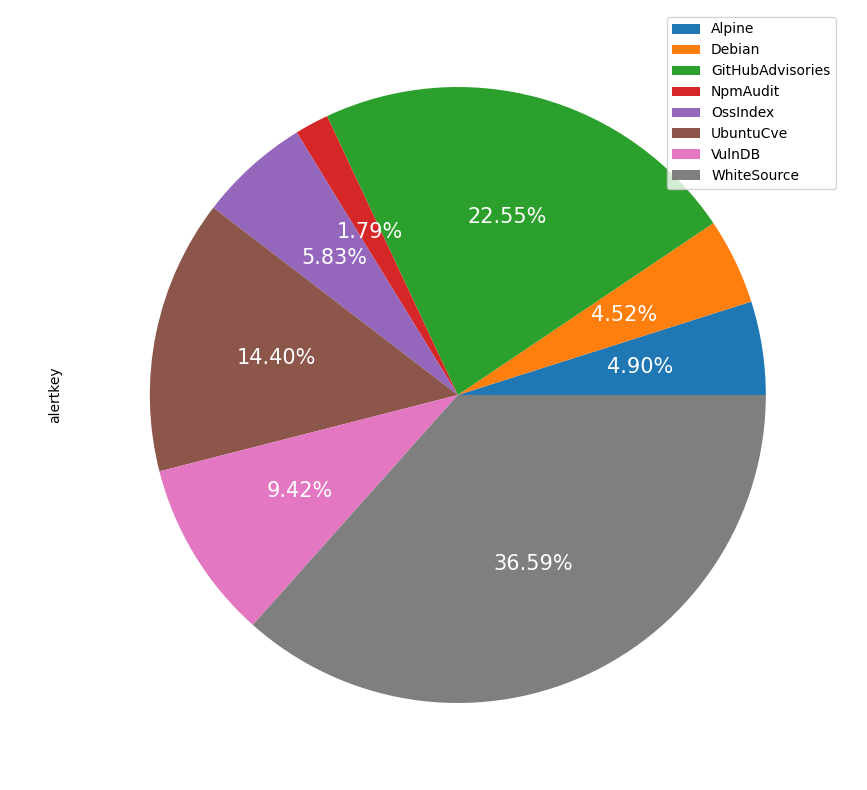

In [75]:
# Alerts distribution by data providers
data_frame[data_frame['component_type'] != 9].groupby('source')['alertkey'] .count() .plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10), autopct='%1.2f%%', legend=True)

In [76]:

# components types that support security vulnerabilities
ct_dict = { "component_type_id" : [1,2,3,6,7,8,9,10,12,13,14],
            "component_type_name" : [ "NuGet", "Npm", "Maven", "RubyGems", "Cargo", "Pip", "File", "Go", "Pod", "Linux", "Conda"]
}
component_types = pd.DataFrame(ct_dict)

In [77]:

# alert severities
sev_dict = { "severity_id" : [0,1,2,3],
            "severity_name" : ["Low", "Medium", "High", "Critical"]
}
severities = pd.DataFrame(sev_dict)

In [78]:
# Percentage of alerts that are only found in GA
ga_alerts = data_frame[data_frame['source'] == 'GitHubAdvisories']
no_ga_alerts = data_frame[data_frame['source'] != 'GitHubAdvisories']
# some alerts are found in multiple sources, doing this we guarantee that we are going to get
# only the alerts that have only one source and that source is GithubAdvisories
only_ga = ga_alerts[~ga_alerts['alertkey'].isin(no_ga_alerts['alertkey'])]
(only_ga.shape[0]/data_frame.shape[0])*100

6.590986106404609

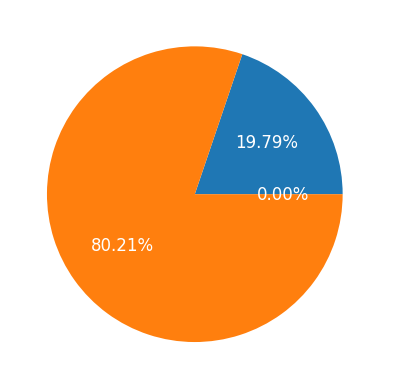

In [79]:
# Distribution of vulnerabilities ids from alerts found only by GA

from matplotlib import pyplot as plt

ghsa = only_ga.title.str.startswith('GHSA', na=False).sum()
cve = only_ga.title.str.startswith('CVE', na=False).sum()
other = only_ga.shape[0] - ghsa - cve

plt.pie([ghsa, cve, other], labels=["GHSA", "CVE", "Other"], textprops={'color':"black", 'fontsize':12}, autopct='%1.2f%%')
plt.show()

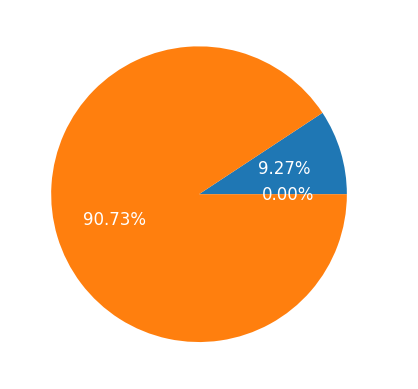

In [80]:
# Distribution of vulnerabilities ids for alerts that were only found by WS

from matplotlib import pyplot as plt


ws = only_ws.title.str.startswith('WS', na=False).sum()
cve = only_ws.title.str.startswith('CVE', na=False).sum()
other = only_ws.shape[0] - ws - cve

plt.pie([ws, cve, other], labels=["WS", "CVE", "Other"], textprops={'color':"black", 'fontsize':12}, autopct='%1.2f%%')
plt.show()

<AxesSubplot: ylabel='alertkey'>

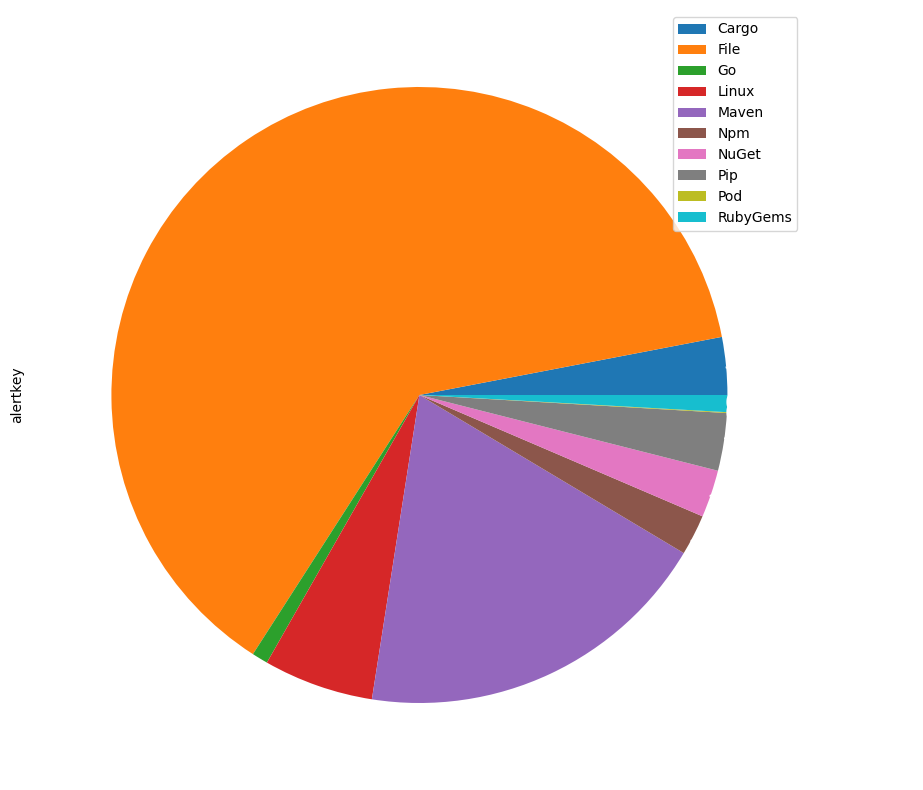

In [81]:
# Component types of the CVE alerts that where only found by WS

ws_cve_alerts = only_ws[only_ws.title.str.startswith('CVE', na=False)]
ws_cve_alerts = ws_cve_alerts.merge(component_types, left_on='component_type', right_on='component_type_id')
ws_cve_alerts.groupby('component_type_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
labeldistance=1.24, legend=True)

In [90]:
# filtered = ws_cve_alerts[(ws_cve_alerts.component_type != 9)& (ws_cve_alerts.component_type != 2) & (ws_cve_alerts.component_type != 1)]
filtered = ws_cve_alerts[(ws_cve_alerts.component_type == 2)]
filtered = filtered[filtered.partitionid == 10]
filtered.head(100)

,partitionid,dataspaceid,repositoryid,alertid,title,alertkey,severity,component_type,source,url,component_type_id,component_type_name
1426,10,1814,2306,2286182,CVE-2019-10794,v6:9736cf51a698473190cabcf2bea48b57,1,2,WhiteSource,https://cve.mitre.org/cgi-bin/cvename.cgi?name...,2,Npm
1427,10,1814,2959,3983711,CVE-2020-8268,v6:d36abd4e29a643bcbafe6a721385d69a,1,2,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,2,Npm
1428,10,1814,2959,4005806,CVE-2020-7770,v6:dc53e7df73314d82abef77ab28d0bfd2,2,2,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,2,Npm
1429,10,1814,139393,4024684,CVE-2020-7773,v6:135be487f37b4152bfc8655320c836ff,1,2,WhiteSource,https://vuln.whitesourcesoftware.com/vulnerabi...,2,Npm


In [ ]:
# Alerts for a specific component type

ws_cve_alerts = only_ws[only_ws.title.str.startswith('CVE', na=False)]
ws_cve_alerts = ws_cve_alerts.merge(component_types, left_on='component_type', right_on='component_type_id')
ws_cve_alerts[ws_cve_alerts.component_type_name == "Maven"]

In [ ]:
# percentage of alerts are only covered by WhiteSource
ws_alerts = data_frame[data_frame['source'] == 'WhiteSource']
no_ws_alerts = data_frame[data_frame['source'] != 'WhiteSource']
only_ws = ws_alerts[~ws_alerts['alertkey'].isin(no_ws_alerts['alertkey'])]
(only_ws.shape[0]/data_frame.shape[0]) * 100

In [ ]:
# percentage of whitesource alerts that are also found in github advisories
ws_alerts_covered_by_ga = ga_alerts[ga_alerts["alertkey"].isin(ws_alerts['alertkey'])]
(ws_alerts_covered_by_ga.shape[0]/ws_alerts.shape[0]) * 100

In [ ]:
# percentage of whitesource alerts that are also found in github advisories considering only component types that both providers support
ws_alerts_covered_by_ga = ga_alerts[ga_alerts["alertkey"].isin(ws_alerts['alertkey'])]
ws_same_ct_alerts = ws_alerts[ws_alerts.component_type.isin(ga_alerts.component_type)]
(ws_alerts_covered_by_ga.shape[0]/ws_same_ct_alerts.shape[0]) * 100

In [ ]:
# Component Types of the alerts that were reported only by WS
ows_ct_data = only_ws.merge(component_types, left_on='component_type', right_on='component_type_id')

ows_ct_data.shape

#ows_ct_data.groupby('component_type_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
#labeldistance=1.24)

In [ ]:
# Components Types that are only covered by WS
ct_only_covered_ws = ows_ct_data[~ows_ct_data["component_type"].isin(no_ws_alerts["component_type"])]["component_type"]
component_types[component_types["component_type_id"].isin(ct_only_covered_ws)]


In [ ]:
# Severity of the alerts that were reported only by WS
ows_sev_data = only_ws.merge(severities, left_on='severity', right_on='severity_id')
ows_sev_data.groupby('severity_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'white'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
labeldistance=1.24, legend=True)

In [ ]:
# Severity of the alerts that were reported only by WS
oga_sev_data = only_ga.merge(severities, left_on='severity', right_on='severity_id')
oga_sev_data.groupby('severity_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'black'}, figsize=(10,10),autopct='%1.2f%%', pctdistance=1.1,
labeldistance=1.24)

In [ ]:
# Component Types of the alerts that were reported only by Github Advisories
oga_ct_data = ga_alerts.merge(component_types, left_on='component_type', right_on='component_type_id')
oga_ct_data.groupby('component_type_name')['alertkey'].count().plot(kind='pie', textprops={'fontsize':15, 'color':'black'}, figsize=(10,10),autopct='%1.2f%%', labeldistance= 1.24)

In [ ]:
# components types that are covered
component_types[ component_types["component_type_id"].isin(ws_alerts_covered_by_ga["component_type"])]

In [ ]:
# Severities of the alerts that are only covered by WS
only_ws.groupby('severity')['alertkey'].count()

In [ ]:
# What components types were not found in alerts from github advisories

component_types[~component_types["component_type_id"].isin(ga_alerts['component_type'])]["component_type_name"]




In [ ]:

data_frame[data_frame["component_type"] == 13].groupby("source")["alertkey"].count()